In [1]:
############### Libraries #####################################
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint

##############

from collections import Counter
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

#from kpal.klib import Profile

######################
import skbio
from skbio.alignment import AlignmentStructure
from skbio.alignment import local_pairwise_align

import Bio
from Bio import Align 
from Bio import pairwise2
from Bio.SeqUtils.ProtParam import ProteinAnalysis
#import warnings
####################
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import svm

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn import manifold

from sklearn.model_selection import train_test_split

from sklearn.utils.fixes import signature

################ decision boundary, libraries #########

from matplotlib.colors import ListedColormap


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs, make_checkerboard

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)#, 
                              #ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#print(__doc__)

#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
##########################
import matplotlib.pyplot as plt

%matplotlib inline

# Load data

In [2]:
##### load training dataset ######
data =  pd.read_csv('dataraning_new_data.csv', delimiter=',') #('training_data.csv', delimiter=',')
data.head()

,Unnamed: 0,Resp,VL.t0,CD4.t0,rtlength,pr_A,pr_C,pr_G,pr_R,pr_T,pr_Y,PR_GC,RT_A,RT_C,RT_G,RT_R,RT_T,RT_Y,RT_GC
0,1,0,4.3,145,1005,104,51,67,2,71,2,0.402730,402,167,210,1,1,1,0.378134
1,2,0,3.6,224,909,110,49,65,73,0,0,0.383838,355,151,193,1,3,203,0.381375
2,3,0,3.2,1017,903,105,47,67,2,74,2,0.389078,360,146,181,1,7,201,0.368243
3,4,0,5.7,206,1455,105,49,71,1,71,0,0.405405,586,245,305,1,1,317,0.378527
4,5,0,3.5,572,903,105,50,69,73,0,0,0.400673,353,150,184,2,5,1,0.374439


In [3]:
####### Number of missing data ########
nb_missing = data.isnull().sum().sum()
nb_missing

0

In [4]:
#### Check where we have (or which feature(s) have ) missing data
data.isnull().sum()


Unnamed: 0    0
Resp          0
VL.t0         0
CD4.t0        0
rtlength      0
pr_A          0
pr_C          0
pr_G          0
pr_R          0
pr_T          0
pr_Y          0
PR_GC         0
RT_A          0
RT_C          0
RT_G          0
RT_R          0
RT_T          0
RT_Y          0
RT_GC         0
dtype: int64

Text(0.5, 0, 'improve 1 or not 0')

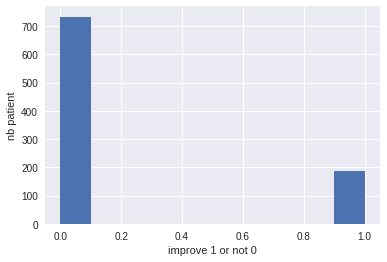

In [5]:
##############  Histogram of improving '1' of responds after 16 weeks of therapy #################
data['Resp'].hist()
plt.ylabel("nb patient")
plt.xlabel("improve 1 or not 0")

# We have imbalanced data

# Pre-Processing

### 1) Imbalanced data: solution

#### 1.1) With SMOTE

In [6]:
data_X = data[['VL.t0','CD4.t0', 'rtlength', 'pr_A', 'pr_C','pr_G', 'pr_R', 'pr_T','pr_Y','PR_GC','RT_A', 'RT_C', 
                  'RT_G', 'RT_R', 'RT_T', 'RT_Y', 'RT_GC']]
# data_X = data[['VL-t0', 'CD4-t0']]

In [7]:
sm = imblearn.over_sampling.SMOTE( sampling_strategy='auto', kind='regular', random_state=0 )
X_resampled1 , y_resampled1 = sm.fit_sample(data_X, data['Resp']) #(data[['VL-t0', 'CD4-t0']], data['Resp'])

In [8]:
print('Original dataset shape:', Counter(data['Resp']))
print('Resampled dataset shape:', Counter(y_resampled1))

Original dataset shape: Counter({0: 733, 1: 187})
Resampled dataset shape: Counter({0: 733, 1: 733})


Text(0.5, 1.0, 'VL-t0 histogram')

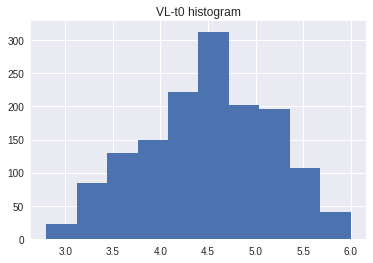

In [9]:
plt.hist(X_resampled1[:,0])
plt.title('VL-t0 histogram')

Text(0.5, 1.0, 'CD4-t0 histogram')

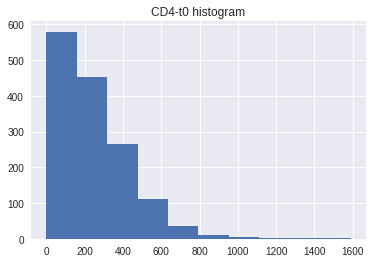

In [10]:
plt.hist(X_resampled1[:,1])
plt.title('CD4-t0 histogram')

#### 1.2) With SMOTENC (for sequence)

In [11]:
#cat_feats = [2,3]
#sm_enc = imblearn.over_sampling.SMOTENC(cat_feats, sampling_strategy='auto')
#X_resampled , y_resampled = sm_enc.fit_sample(data, data['Resp'])

In [12]:
#print('Original dataset shape:', Counter(data['Resp']))
#print('Resampled dataset shape:', Counter(y_resampled))

In [13]:
#plt.hist(X_resampled[:,0])

# I) T-SNE Transformation

In [14]:
manifold_tsne = manifold.TSNE(n_components=2, random_state=0) # n_components=3
X_resampled1_tsne = manifold_tsne.fit_transform(X_resampled1)

In [15]:
#manifold.TSNE

## Split Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled1_tsne, y_resampled1, test_size=.1, random_state =0)

## I.1) K-Nearest-Neighbors (KNN) Algorithm

### Random Search: Bayesian Optimization

In [17]:
# build a classifier
clf = KNeighborsClassifier(n_jobs=2)

# specify parameters and distributions to sample from
param_dist = {"n_neighbors": sp_randint(2,11),
              "weights": ['uniform', 'distance'],
              "p": [1,2],
              "metric": ['minkowski', 'euclidean']}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)


random_search.fit(X_train, y_train)

#random_search.cv_results_['params']
best_params = random_search.best_params_
print(best_params)

{'n_neighbors': 2, 'p': 1, 'metric': 'euclidean', 'weights': 'distance'}


In [18]:
# Clustering  with KNN classifier
modelknn = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2, metric='euclidean', n_jobs=2)
modelknn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=2, n_neighbors=3, p=2,
           weights='uniform')

In [19]:
knn_accur = sklearn.model_selection.cross_val_score(modelknn, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(knn_accur)
print(knn_accur.mean())

[0.73106061 0.74621212 0.77272727 0.75       0.73003802]
0.7460076045627376


In [20]:
modelknn_predict = modelknn.predict(X_test)

In [21]:
knn_accur_pred = metrics.accuracy_score(y_test, modelknn_predict)
print(knn_accur_pred)

0.7414965986394558


In [22]:
##### confusion matrix ######
conf_mat_knn = metrics.confusion_matrix(y_true=y_test , y_pred=modelknn_predict)
print('%%%%%%%%% Confusion Matrix: KNN %%%%%%%%%\n')
print(conf_mat_knn)


%%%%%%%%% Confusion Matrix: KNN %%%%%%%%%

[[56 22]
 [16 53]]


In [23]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: KNN %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, modelknn_predict))

%%%%%%%%%%%%%% Classification Report: KNN %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        78
           1       0.71      0.77      0.74        69

   micro avg       0.74      0.74      0.74       147
   macro avg       0.74      0.74      0.74       147
weighted avg       0.74      0.74      0.74       147



#### Confusion Matrix

In [24]:
##### confusion matrix ######
conf_mat_knn = metrics.confusion_matrix(y_true=y_test , y_pred=modelknn_predict)
print('Confusion Matrix KNN: \n', conf_mat_knn)

Confusion Matrix KNN: 
 [[56 22]
 [16 53]]


In [25]:
#from sklearn.metrics import average_precision_score
average_precision_knn = metrics.average_precision_score(y_test, modelknn_predict)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_knn))

Average precision-recall score: 0.65


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.65')

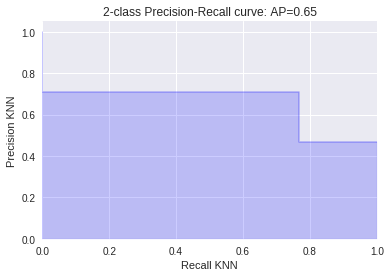

In [26]:
#from sklearn.metrics import precision_recall_curve
#import matplotlib.pyplot as plt


precision_knn, recall_knn, _ = metrics.precision_recall_curve(y_test, modelknn_predict)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_knn, precision_knn, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_knn, precision_knn, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall KNN')
plt.ylabel('Precision KNN')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_knn))

In [27]:
print(recall_knn)

[1.         0.76811594 0.        ]


## I.2) Random Forest Classifier

In [28]:
###### Best Hyper-parameters ###############

# build a classifier
clf = RandomForestClassifier(n_estimators=20)

# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(3, 12),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)


random_search.fit(X_train, y_train)

#random_search.cv_results_['params']
best_params = random_search.best_params_
print(best_params)

{'bootstrap': True, 'max_depth': 10, 'criterion': 'gini', 'min_samples_split': 4}


In [29]:
model_RandForest = RandomForestClassifier(bootstrap=best_params['bootstrap'], max_depth=best_params['max_depth'], 
                                          n_estimators=20, criterion=best_params['criterion'], class_weight="balanced",
                                          n_jobs=2, min_samples_split =best_params['min_samples_split'])
model_RandForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [30]:
model_RandForest_accur = sklearn.model_selection.cross_val_score(model_RandForest, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=3)

In [31]:
print(model_RandForest_accur)
print(model_RandForest_accur.mean())

[0.75056689 0.74943052 0.72665148]
0.742216299326615


In [32]:
model_RandForest_pred = model_RandForest.predict(X_test)
model_RandForest_accur_pred = metrics.accuracy_score(y_test, model_RandForest_pred)
print(model_RandForest_accur_pred)

0.7414965986394558


In [33]:
##### confusion matrix ######
conf_mat_RandForest = metrics.confusion_matrix(y_true=y_test , y_pred=model_RandForest_pred)
print('%%%%%%%%% Confusion Matrix: Random Forest %%%%%%%%%\n')
print(conf_mat_RandForest)


%%%%%%%%% Confusion Matrix: Random Forest %%%%%%%%%

[[59 19]
 [19 50]]


In [34]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Random Forest %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_RandForest_pred))

%%%%%%%%%%%%%% Classification Report: Random Forest %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        78
           1       0.72      0.72      0.72        69

   micro avg       0.74      0.74      0.74       147
   macro avg       0.74      0.74      0.74       147
weighted avg       0.74      0.74      0.74       147



## I.3) Decision Tree Classifier

In [35]:
###### Best Hyper-parameters ###############

# build a classifier
clf = DecisionTreeClassifier()

# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(2, 40),
              "criterion": ["gini", "entropy"],
              "random_state": sp_randint(0,243)}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)


random_search.fit(X_train, y_train)

#random_search.cv_results_['params']
best_params = random_search.best_params_
print(best_params)

{'max_depth': 27, 'criterion': 'entropy', 'random_state': 92}


In [36]:
model_decision_tree = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion']
                                             ,random_state= best_params['random_state'])#, class_weight='balanced')
model_decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=27,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=92,
            splitter='best')

In [37]:
model_decision_tree_accur = sklearn.model_selection.cross_val_score(model_decision_tree, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_decision_tree_accur)
print(model_decision_tree_accur.mean())

[0.75757576 0.76515152 0.79166667 0.71212121 0.74144487]
0.7535920036870607


In [38]:
model_decision_tree_pred = model_decision_tree.predict(X_test)
model_decision_tree_accur_pred = metrics.accuracy_score(y_test, model_decision_tree_pred)
print(model_decision_tree_accur_pred)

0.7278911564625851


In [39]:
##### confusion matrix ######
conf_mat_decision_tree = metrics.confusion_matrix(y_true=y_test , y_pred=model_decision_tree_pred)
print('%%%%%%%%% Confusion Matrix: Decision Tree %%%%%%%%%\n')
print(conf_mat_decision_tree)


%%%%%%%%% Confusion Matrix: Decision Tree %%%%%%%%%

[[56 22]
 [18 51]]


In [40]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Decision Tree %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_decision_tree_pred))


%%%%%%%%%%%%%% Classification Report: Decision Tree %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.76      0.72      0.74        78
           1       0.70      0.74      0.72        69

   micro avg       0.73      0.73      0.73       147
   macro avg       0.73      0.73      0.73       147
weighted avg       0.73      0.73      0.73       147



### Plottting Decision Boundaries

In [ ]:
datasets = [make_moons(noise=0.3, random_state=0)
            ,make_circles(noise=0.2, factor=0.5, random_state=1)
            ,make_blobs()
           ]

names = ["Decision Tree","Random Forest", "KNN"]
# Creating a Python List with our three Tree classifiers
treeclassifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(bootstrap=True, max_depth=5, n_estimators=100, max_features=None, class_weight="balanced" ),
    KNeighborsClassifier()]
#"balanced_subsample"

In [ ]:
figure = plt.figure(figsize=(12, 10))
h = 0.02
i = 1
# iterate over datasets
for ds in datasets:

    x_min, x_max = X_resampled1_tsne[:, 0].min() - .5, X_resampled1_tsne[:, 0].max() + .5
    y_min, y_max = X_resampled1_tsne[:, 1].min() - .5, X_resampled1_tsne[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.jet
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(treeclassifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.7)
    # and testing points
    #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, treeclassifiers):
        ax = plt.subplot(len(datasets), len(treeclassifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)


        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.jet, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.6, linewidths=0.6, edgecolors="white")
        # and testing points
        #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   #alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

## I.4) Logistic Regression

In [ ]:
# ###### Best Hyper-parameters ###############

# # build a classifier
# clf = LogisticRegression(multi_class='auto')

# # specify parameters and distributions to sample from
# param_dist = {"C": [0.01, 0.1, 1],
#               "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#               "random_state": sp_randint(0,243)}

# # run randomized search
# n_iter_search = 20
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search, cv=5)


# random_search.fit(X_train, y_train)

# #random_search.cv_results_['params']
# best_params = random_search.best_params_
# print(best_params)

In [ ]:
model_logistic_reg = LogisticRegression(C=0.01, solver='liblinear', multi_class='auto', random_state=0)
model_logistic_reg.fit(X_train, y_train)

In [ ]:
model_logistReg_accur = sklearn.model_selection.cross_val_score(model_logistic_reg, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_logistReg_accur)
print(model_logistReg_accur.mean())

In [ ]:
model_logistReg_pred = model_decision_tree.predict(X_test)
model_logistReg_accur_pred = metrics.accuracy_score(y_test, model_logistReg_pred)
print(model_logistReg_accur_pred)

In [ ]:
##### confusion matrix ######
conf_mat_logistReg = metrics.confusion_matrix(y_true=y_test , y_pred=model_logistReg_pred)
print('%%%%%%%%% Confusion Matrix: Logistic Regression %%%%%%%%%\n')
print(conf_mat_logistReg)


In [ ]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Logistic Regression %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_logistReg_pred))

## I.5) Gaussian Naives Bayesian

In [ ]:
model_gaus_nb = GaussianNB()
model_gaus_nb.fit(X_train, y_train)

In [ ]:
model_gaus_nb_accur = sklearn.model_selection.cross_val_score(model_gaus_nb, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_gaus_nb_accur)
print(model_gaus_nb_accur.mean())

In [ ]:
model_gaus_nb_pred = model_gaus_nb.predict(X_test)
model_gaus_nb_accur_pred = metrics.accuracy_score(y_test, model_gaus_nb_pred)
print(model_gaus_nb_accur_pred)

In [ ]:
##### confusion matrix ######
conf_mat_gaus_nb = metrics.confusion_matrix(y_true=y_test , y_pred=model_gaus_nb_pred)
print('%%%%%%%%% Confusion Matrix: Gaussian Naives Bayesian %%%%%%%%%\n')
print(conf_mat_gaus_nb)


In [ ]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Gaussian Naives Bayesian %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_gaus_nb_pred))

## I.6) XGBoost Classifier

In [ ]:
model_xgbc = XGBClassifier(learning_rate=0.5, reg_lambda=0.1, n_jobs=3)
model_xgbc.fit(X_train, y_train)

In [ ]:
model_xgbc_accur = sklearn.model_selection.cross_val_score(model_xgbc, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_xgbc_accur)
print(model_xgbc_accur.mean())

In [ ]:
model_xgbc_pred = model_xgbc.predict(X_test)
model_xgbc_accur_pred = metrics.accuracy_score(y_test, model_xgbc_pred)
print(model_xgbc_accur_pred)

In [ ]:
##### confusion matrix ######
conf_mat_xgbc = metrics.confusion_matrix(y_true=y_test , y_pred=model_xgbc_pred)
print('%%%%%%%%% Confusion Matrix:  XGBoost Classifier %%%%%%%%%\n')
print(conf_mat_xgbc)


In [ ]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: XGBoost Classifier %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_xgbc_pred))

## I.7) KMeans

In [ ]:
modelkmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=80) #'random', max_iter=100, n_init=80)
modelkmeans.fit(X_train)

In [ ]:
modelkmeans_accur = sklearn.model_selection.cross_val_score(modelkmeans, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(modelkmeans_accur)
print(modelkmeans_accur.mean())

In [ ]:
modelkmeans_pred = modelkmeans.predict(X_test)
modelkmeans_accur_pred = metrics.accuracy_score(y_test, modelkmeans_pred)
print(modelkmeans_accur_pred)

In [ ]:
##### confusion matrix ######
conf_mat_kmeans = metrics.confusion_matrix(y_true=y_test , y_pred=modelkmeans_pred)
print('%%%%%%%%% Confusion Matrix: KMeans %%%%%%%%%\n')
print(conf_mat_kmeans)


In [ ]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: K-Means %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, modelkmeans_pred))

## I.8) SVC

In [ ]:
model_svc = svm.SVC(gamma='scale', kernel='poly', degree=3, class_weight= "balanced")
model_svc.fit(X_train, y_train)  
# kernel='rbf', degree=3,
#It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable.
#degree  for 'poly'

In [ ]:
model_svc_accur = sklearn.model_selection.cross_val_score(model_svc, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_svc_accur)
print(model_svc_accur.mean())

In [ ]:
model_svc_pred = model_svc.predict(X_test)
model_svc_accur_pred = metrics.accuracy_score(y_test, model_svc_pred)
print(model_svc_accur_pred)

In [ ]:
##### confusion matrix ######
conf_mat_svc = metrics.confusion_matrix(y_true=y_test , y_pred=model_svc_pred)
print('%%%%%%%%% Confusion Matrix: Support Vector Classifier %%%%%%%%%\n')
print(conf_mat_svc)


In [ ]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Support Vector Classifier %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_svc_pred))

## I.9) Structural SVM